In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
# using JLD
using Plots
pyplot()  

Plots.PyPlotBackend()

In [4]:
using JLD2

In [5]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: C:\Users\liyux\.julia\packages\StructArrays\bekT9\src\refarray.jl no longer exists, deleted all methods
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:650
┌ Warning: C:\Users\liyux\.julia\packages\StructArrays\bekT9\src\groupjoin.jl no longer exists, deleted all methods
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:650
┌ Error: Failed to revise C:\Users\liyux\.julia\packages\StructArrays\bekT9\src\StructArrays.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\StructArrays\\bekT9\\src\\StructArrays.jl:28", ArgumentError("Package StructArrays does not have Adapt in its dependencies:\n- If you have StructArrays checked out for development and have\n  added Adapt as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with StructArrays"), Any[(top-level scope at StructArrays.jl:28, 1)])
└ @ Revise C:\User

# the plate code initialization

### Physical parameters

In [6]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [7]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [8]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.15)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

Δt = 1e-3

0.001

### Set up the boundary of the domain

In [9]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 368 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [10]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0*10
hc = 2000.0
Tc = 0.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

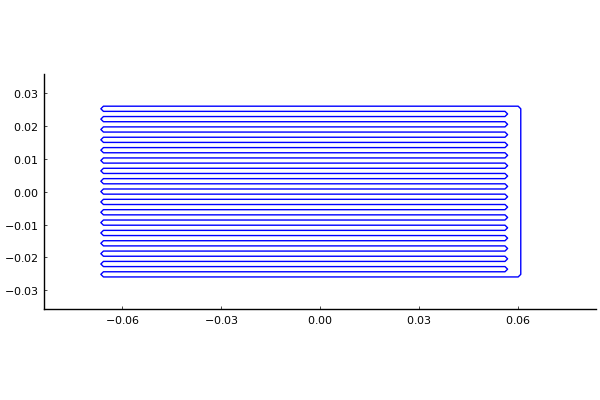

In [11]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly*0.8
height = Lx*0.8
gap = 2*d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [12]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [13]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


#### Initialize state, and create the integrator

In [14]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [15]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


In [16]:
@time step!(integrator,1.0)
maximum(integrator.u[:])

136.482355 seconds (7.84 M allocations: 15.999 GiB, 2.38% gc time)


30.611830803171014

### Set the relative temperature back to [K]

In [17]:
T0 = 295.0 #[K]
integrator.u += T0 - integrator.u[1,1]

(Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

### Plotting temperature contours

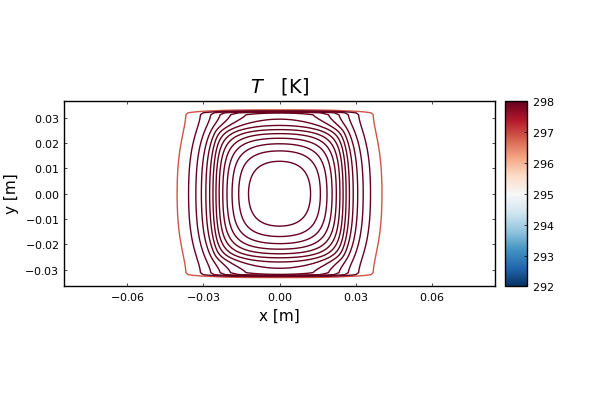

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [18]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clims=(T0-3.0,T0+3.0),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [19]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

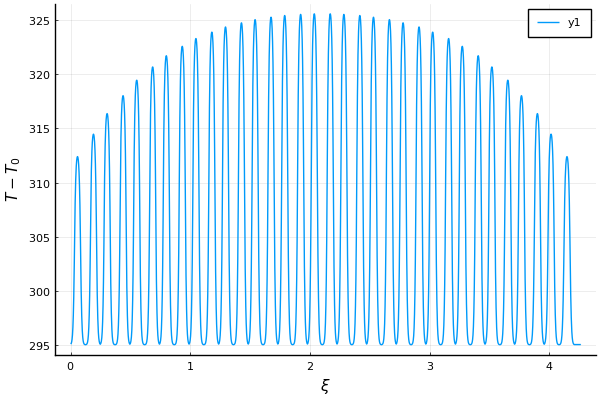

In [20]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [21]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [22]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  2.32E+02; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.64E+02;


In [23]:
    
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [24]:
    nucleatenum = 16
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [25]:
tube = Tube(d,L,L2D,angle,closedornot);

In [26]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [27]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [28]:
numofX=16
Xps = sort(rand(2*numofX).*L);
Xp1s = Xps[1:2:end];
Xp2s = Xps[2:2:end];

dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
X0 = map(tuple,Xp1s,Xp2s);


In [29]:
N=numpts(ohp)
# X0 = [(L/4, L*3/4)]
# dXdt0 = [(0.0,0.0)]
ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [30]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 4.64E+02
P = 0*Xp1s .+ 1.0;
δ = 0*Xp1s .+ 2.78E-02;
vapors=Vapor(γ,Hδ,P,δ);

In [31]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [32]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [33]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [34]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [35]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

### solve OHP (with nondimentional wall tempeature = 1.0)

In [36]:
tstep=1e-4
# tstep=5e-5*t_to_nondi_t

p = sys0
tspan = (0.0, 0.1);
prob = ODEProblem(ODE_innertube, u, tspan, p)

integrator_tube = init(deepcopy(prob), SSPRK22(), dt=tstep, callback=cbst);

@time solve!(integrator_tube);


LoadError: [91mBoundsError: attempt to access 1000-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64 at index [49.35512106534889][39m

In [37]:
p = deepcopy(getcurrentsys(integrator_tube.sol[end],sys0));
p.liquid.Xp;

In [38]:
sol = integrator_tube.sol
sysfinal = getcurrentsys.(sol.u,[sys0]);

# combine inner tube and plate together

In [39]:
tspan = (0.0, 2.0);
dt_record = tspan[2] /100;
tstep=5e-4;

In [40]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

In [41]:
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, callback=cbst)

t: 0.0
u: 2087-element Array{Float64,1}:
  0.5150039830303732
  1.9441183724499234
  2.354417147020156
  5.081507462410823
  6.1219057313215615
  6.303123465696738
  6.380958473784682
  7.351753690325289
  7.607619958031593
  8.427689772935853
  8.747252929107532
  9.559688138402956
 11.56171970470875
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [42]:
plate_hist = []
tube_hist  = []
currentsys = getcurrentsys(integrator_tube.u,sys0)

PHPSystem(Tube(0.00656, 35.0, 1.0, 0.0, true), Evaporator([(1.0, 3.0)], [0.0]), Condenser(1.0, [(0.0, 1.0), (3.0, 4.0)], 0.0), Liquid(232.0, 102.593344, 49.49747468305833, 205000.0, [(0.5150039830303732, 1.9441183724499234), (2.354417147020156, 5.081507462410823), (6.1219057313215615, 6.303123465696738), (6.380958473784682, 7.351753690325289), (7.607619958031593, 8.427689772935853), (8.747252929107532, 9.559688138402956), (11.56171970470875, 12.216635196619233), (12.240289457906805, 12.989166955785853), (13.932864275461474, 14.015461373368861), (16.745171043022044, 17.10442917770079), (17.38782919758014, 18.033153389035792), (19.928255301557627, 20.030491230396212), (20.364219813576543, 23.028692070136547), (25.061712112050344, 27.382894315907247), (28.379977661165846, 30.327892157039233), (32.27562657617725, 34.79519899003211)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (

In [43]:

@time for t in tspan[1]:tstep:tspan[2]
    


    currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
    currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
    nondi_qtmp = sys_to_heatflux(currentsys)
    qtmp = nondi_Q_to_Q*nondi_qtmp
    set_linesource_strength!(sys,qtmp)
    
    
    # reinitialize the integrator_plate to avoid some mysterious problems
    integrator_plate = init(deepcopy(integrator_plate.u),(integrator_plate.t,integrator_plate.t + tstep),sys)
    step!(integrator_plate,tstep, true)
    
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, SSPRK22(), callback=cbst, dt=1e-4);
    solve!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.020000000000000014
0.04000000000000003
0.060000000000000046
0.08000000000000006
Boiled!0.02830000000000002
0.10000000000000007
0.12000000000000009
0.1400000000000001
0.16000000000000011
0.18000000000000013
Boiled!0.05660000000000004
0.20000000000000015
0.22000000000000017
0.24000000000000019
0.2600000000000002
0.2800000000000002
0.3000000000000002
0.32000000000000023
0.34000000000000025
0.36000000000000026
0.3800000000000003
0.4000000000000003
0.4200000000000003
0.44000000000000034
0.46000000000000035
0.48000000000000037
Boiled!0.14150000000000007
0.5000000000000003
merged!
0.5199999999999981
0.5399999999999959
0.5599999999999937
0.5799999999999915
Boiled!0.16979999999999695
0.5999999999999893
0.6199999999999871
0.6399999999999849
0.6599999999999827
0.6799999999999805
Boiled!0.19809999999999384
0.6999999999999783


LoadError: [91mknot-vectors must be sorted in increasing order[39m

In [44]:
p1,p2,p3,p4 = sys_interpolation(integrator_tube.p)

(3654-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64:
 1.0055540134365968
 1.005558247017068
 1.0055589363341688
 1.0055601853001268
 1.005560964246319
 1.005561539571521
 1.0055620131619711
 1.0055622303165264
 1.0055625913066477
 1.005562550145169
 1.0055632047126044
 1.0055643273164219
 1.0055667920270384
 ⋮
 1.0055242978852716
 1.005521305364721
 1.0055204420892907
 1.005523632142786
 1.0055278484556065
 1.0055344321168431
 1.0055378489312403
 1.0055365606574087
 1.0054509254938047
 1.0054486137652254
 1.0055360265019304
 1.0055468447901716, 2032-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64:
 1.0056313053275343
 1.0056313053275343
 1.0056313053275343
 1.0013762370306747
 1.0013659840236007
 1.001357316731403
 1.0013496929130272
 1.0013436307933676
 1.0013401975434029
 1.0013398892855172
 1.0013415784043656
 1.0013432

In [45]:
p4

42-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64:
 1.0539659535337538
 1.0539659535337538
 1.0543793649415663
 1.0543793649415663
 1.058152368628821
 1.058152368628821
 1.0626119495926822
 1.0626119495926822
 1.1770209243543865
 1.1770209243543865
 0.7957197921075444
 0.7957197921075444
 1.057676163850153
 ⋮
 1.0562442056089762
 1.0562442056089762
 1.0562548593001992
 1.0562548593001992
 1.0556719300811885
 1.0556719300811885
 1.0552665978397908
 1.0552665978397908
 1.0544390193391204
 1.0544390193391204
 1.0539659535337538
 1.0539659535337538

In [46]:
integrator_tube.p.mapping.θ_interp_liquidtowall

2032-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64:
 1.0056313053275343
 1.0056313053275343
 1.0056313053275343
 1.0013762370306747
 1.0013659840236007
 1.001357316731403
 1.0013496929130272
 1.0013436307933676
 1.0013401975434029
 1.0013398892855172
 1.0013415784043656
 1.0013432102728332
 1.0013431906239731
 ⋮
 1.0006551517551718
 1.0006781284265673
 1.0007017722824258
 1.0007267375671551
 1.0007554434041843
 1.000791794443998
 1.0008419763365939
 1.0009168070956473
 1.001040061322801
 1.0012105352491742
 1.0012105352491742
 1.0056313053275343

In [47]:
boiling_affect!(integrator_tube)

LoadError: [91mknot-vectors must be sorted in increasing order[39m

In [48]:
sysfinal[7].tube.d

0.00656

In [49]:
sysfinal = []
for i = 1:length(tube_hist)
    plate_hist[i].u += T0 - plate_hist[i].u[1,1]
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [50]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

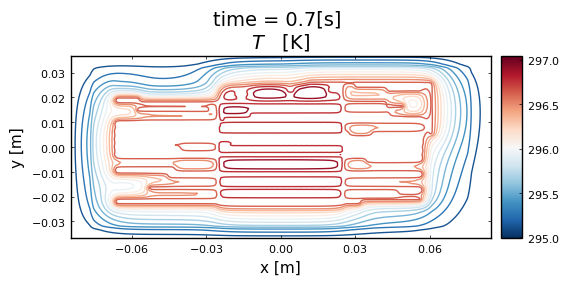

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
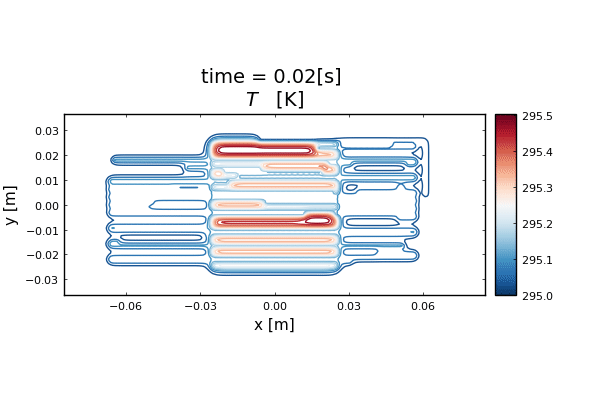

In [51]:
@gif for i = 1:1:length(plate_hist)
Tmin = minimum(temperature(plate_hist[i])[:])
Tmax = maximum(temperature(plate_hist[i])[:])   
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T \quad [\mathrm{K}]"))
# plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

In [52]:
xc, yc = coordinates(temperature(plate_hist[end]),sys.grid);

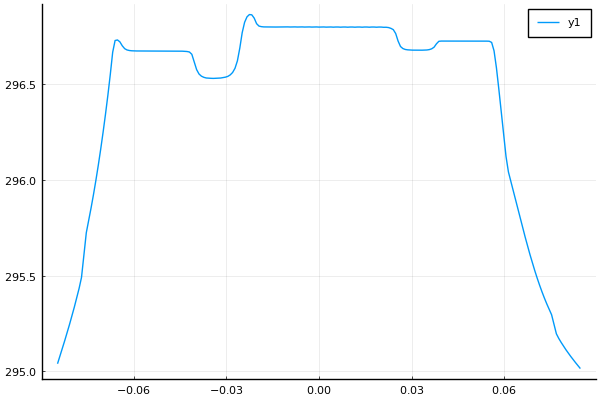

In [53]:
plot(xc,temperature(plate_hist[end])[:,floor(Int,size(sys.grid,2)/2)])

# plot the OHP

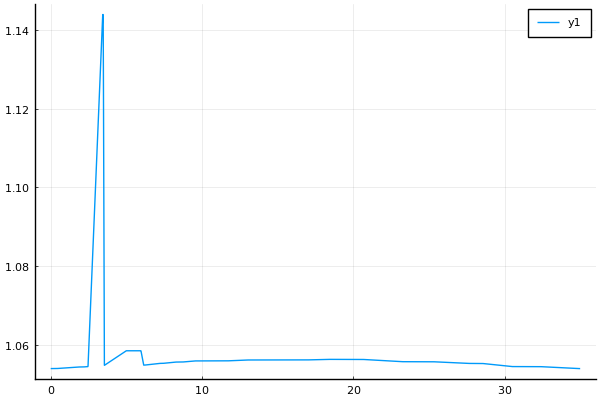

In [54]:
p = 0:0.01:35
plot(p,sysfinal[end].mapping.P_interp_liquidtowall.(p))

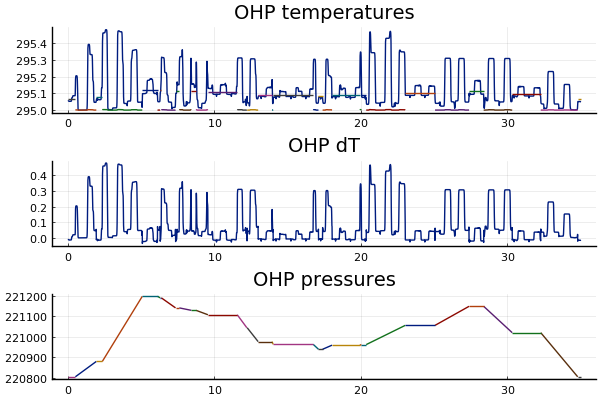

In [55]:
plot(sysfinal[1])

In [56]:
typeof(sysfinal[1].wall.Xarray)

Array{Float64,1}

In [57]:
plot(sysfinal[1].wall.Xarray,sysfinal[1])

LoadError: [91mCannot convert PHPSystem to series data for plotting[39m

In [58]:
typeof(DeltaT_OHP)

LoadError: [91mUndefVarError: DeltaT_OHP not defined[39m

In [59]:
length(y)

3654

In [60]:
@recipe function f(::Type{PHPSystem},val::PHPSystem) 

    
    layout := (2,1)
 
    x1,y1 = stackXpTemp(val)
    @series begin
        subplot := 1
        
        
        legend := false
        color_palette  := :seaborn_dark
        title := "OHP temperatures"
        y1 = y1 .* T0

        
        
        x1,y1
    end

    x2,y2 = stackXpTemp(val)
    @series begin
        subplot := 2
   
        legend := false
        color_palette  := :seaborn_dark
        title := "OHP dT"
        
        popfirst!(x2)
        popfirst!(y2)
        
        for i = 1:length(y2)
            y2[i] -= val.mapping.θ_interp_walltoliquid.(x2[i])
        end
        
        x2,y2
    end
end

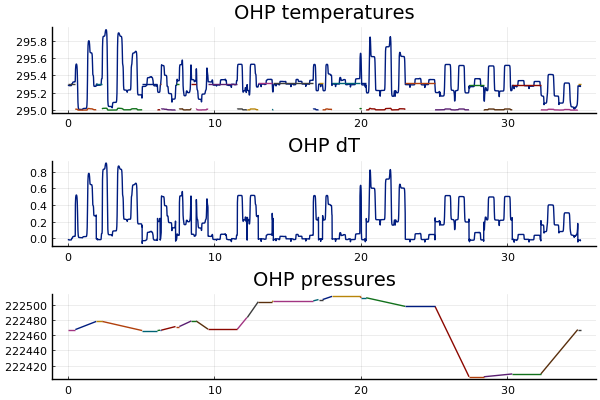

In [61]:
plot(sysfinal[3])

In [62]:
all_θ  = Vector{Float64}[] 

Array{Float64,1}[]

In [63]:
rand(10)

10-element Array{Float64,1}:
 0.5480603316190809
 0.9607377210171071
 0.16782665820974496
 0.13057320952634188
 0.5249473246929324
 0.9365603885750249
 0.9587132964141438
 0.5525521244177485
 0.9495303646838145
 0.4267740472923154

In [64]:
push!(all_θ,10.0)

LoadError: [91mMethodError: [0mCannot `convert` an object of type [92mFloat64[39m[0m to an object of type [91mArray{Float64,1}[39m[39m
[91m[0mClosest candidates are:[39m
[91m[0m  convert(::Type{Array{Float64,1}}, [91m::Sundials.NVector[39m) at C:\Users\liyux\.julia\packages\Sundials\sB5CR\src\nvector_wrapper.jl:59[39m
[91m[0m  convert(::Type{Array{Float64,1}}, [91m::Ptr{Sundials._generic_N_Vector}[39m) at C:\Users\liyux\.julia\packages\Sundials\sB5CR\src\nvector_wrapper.jl:82[39m
[91m[0m  convert(::Type{Array{T,N}}, [91m::StaticArrays.SizedArray{S,T,N,M} where M[39m) where {T, S, N} at C:\Users\liyux\.julia\packages\StaticArrays\LJQEe\src\SizedArray.jl:72[39m
[91m[0m  ...[39m

In [65]:
v1,v2 = stackXpTemp(sysfinal[end])

v1
v2

42-element Array{Any,1}:
 [1.0055458369067938, 1.005550039473508, 1.0055507544938238, 1.0055520008265324, 1.0055527803005742, 1.0055533550239077, 1.0055538274494942, 1.0055540469986959, 1.0055544057420949, 1.0055543703458107  …  1.0055126007530846, 1.005515791272551, 1.005520022494499, 1.0055265822863564, 1.0055299834318079, 1.0055286184830887, 1.0054430908606267, 1.0054408208638, 1.0055280873724062, 1.005538761231285]
 [1.0013847113174643, 1.0013736911123128, 1.0013635195577832, 1.0013549176590357, 1.001347357329035, 1.0013413542498684, 1.0013379636442343, 1.0013376688346032, 1.0013393475993384, 1.0013409588847078  …  1.0013722157597866, 1.0013473691291954, 1.0013258917811823, 1.0013072969199874, 1.001290136993074, 1.0012745613910203, 1.0012659169482556, 1.0012683400128366, 1.0012883567679518, 1.0013322371857967]
 [1.001278968685247, 1.0012728056553997, 1.001234229858887, 1.001268872276644, 1.0013016324499942, 1.00133130438446, 1.0013597514013965, 1.001387426751538, 1.0014144341422508

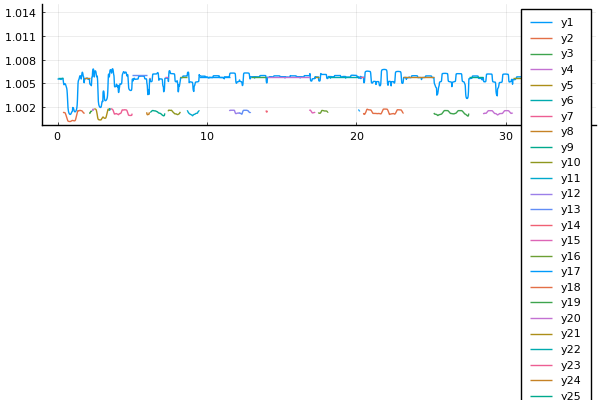

In [66]:
plot(v1,v2)

In [67]:
function stackXpTemp(val::PHPSystem)
    Xpvapor = getXpvapor(val.liquid.Xp,val.tube.L,val.tube.closedornot)
    θvapor  = nondi_PtoT.(val.vapor.P)
    Xp = val.liquid.Xp
    
    all_θ  = [] 
    all_Xp = [] 
    
    push!(all_Xp,val.wall.Xarray); push!(all_θ, val.wall.θarray)
    
    j=1
    while j <= length(Xp)
        if Xp[j][end] >= Xp[j][1]
            push!(all_Xp,val.liquid.Xarrays[j]); push!(all_θ, val.liquid.θarrays[j])
            else 
            # find the index at the end
            index = findfirst(x->x <= sysfinal[i].liquid.Xarrays[j][end], sysfinal[i].liquid.Xarrays[j])
            
            push!(all_Xp,val.liquid.Xarrays[j][1:index-1]); push!(all_θ, val.liquid.θarrays[j][1:index-1])
            push!(all_Xp,val.liquid.Xarrays[j][index:end]); push!(all_θ, val.liquid.θarrays[j][index:end])
        end
        
        j += 1
    end
    
    
    j=1
    while j <= length(Xpvapor)
        if Xpvapor[j][end] >= Xpvapor[j][1]
            push!(all_Xp,[Xpvapor[j][1],Xpvapor[j][end]]); push!(all_θ,[θvapor[j], θvapor[j]])
            else
            push!(all_Xp,[0.0,Xpvapor[j][end]]); push!(all_θ,[θvapor[j], θvapor[j]])
            push!(all_Xp,[Xpvapor[j][1],L]); push!(all_θ,[θvapor[j], θvapor[j]])
        end
        
        j += 1
    end
    
    return all_Xp,all_θ
end

stackXpTemp (generic function with 1 method)

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warnin

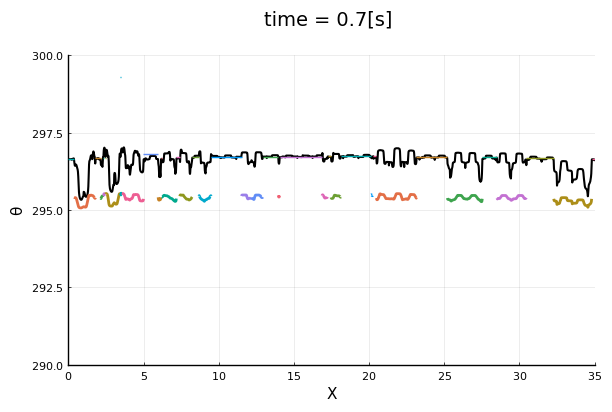

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
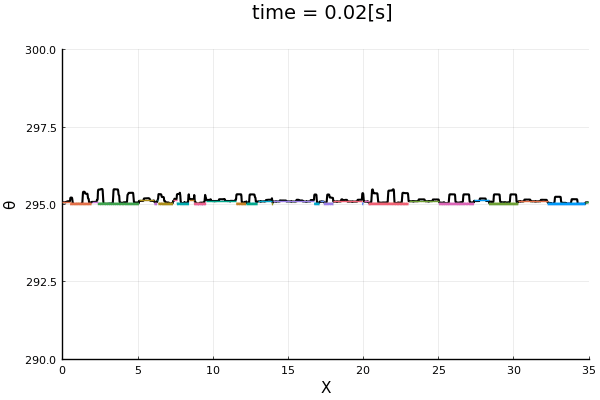

In [68]:
# closed loop plot
@gif for i=1:2:length(sysfinal)
# @gif for i=1:1:80

        
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
#     θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    θvapor  = nondi_PtoT.(sysfinal[i].vapor.P)
    Xp = sysfinal[i].liquid.Xp
    
#     sysfinal[i].wall.θarray = di_T_to_nondi_T(temperature_linesource(plate_hist[i]))
    
    plt = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray .* T0], linewidth=1.5, ylim=(290,300), color = [:black],legend=:none, labels = "θwall", xlabel="X", ylabel="θ", title=(string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",)),xlim=(0,sysfinal[i].tube.L))
    
    
    j=1
    while j <= length(Xp)
        if Xp[j][end] >= Xp[j][1]
            plot!(plt, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]] .* T0, linewidth=2, labels = string("θliquid ",j))
            else 
            # find the index at the end
            index = findfirst(x->x <= sysfinal[i].liquid.Xarrays[j][end], sysfinal[i].liquid.Xarrays[j])
            
            plot!(plt, [sysfinal[i].liquid.Xarrays[j][1:index-1]],[sysfinal[i].liquid.θarrays[j][1:index-1]] .* T0, linewidth=2, labels = string("θliquid ",j))
            plot!(plt, [sysfinal[i].liquid.Xarrays[j][index:end]],[sysfinal[i].liquid.θarrays[j][index:end]] .* T0, linewidth=2, labels = string("θliquid ",j))

        end
        
        j += 1
    end

        j=1
    while j <= length(Xpvapor)
        if Xpvapor[j][end] >= Xpvapor[j][1]
            plot!(plt,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]] .* T0, labels = string("θvapor ",j))
            else
            
            plot!(plt,[0.0,Xpvapor[j][end]],[θvapor[j]] .* T0, labels = string("θvapor ",j))
            plot!(plt,[Xpvapor[j][1],L],[θvapor[j]] .* T0, labels = string("θvapor ",j))

        end
        
        j += 1
    end
    
#     j = 1
#     plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
#     plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))
    
#     j = 2
#     while j  <= length(θvapor) 
    
#         plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
#         j += 1
#     end

#     vline!( p, [collect(0:2:4)], color=[:blue,:red], width=196, alpha=[0.3,0.3,0.3],labels = "")
    
    end 

In [69]:
# # @gif for i = 1:5:length(sysfinal)
# i=100
#     Htmp = sys_to_Harray(sysfinal[i])
# #         set_linesource_strength!(sys,qtmp)
#     plot(sysfinal[i].wall.Xarray,Htmp)
# # end

In [70]:
# @gif for i=1:100

# # i=100
#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x [m]",ylabel="y [m]")
# end

In [71]:
# savefig("OHP.pdf")

In [72]:
integrator_plate.t

0.7014999999999781

In [73]:
save("plate_OHP.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [74]:
save("tube_OHP.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

# temperature difference with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [75]:
temp_evaporator = temperature(plate_hist[end])[110,48]

temp_condenser_1 = temperature(plate_hist[end])[44,48]
temp_condenser_2 = temperature(plate_hist[end])[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser) # K

0.09899473455499219

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [76]:
tempdiff_maximum = maximum(temperature(plate_hist[end]))-minimum(temperature(plate_hist[end])) # K

2.0386860215427305

# thermal conductance with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [77]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

404.0618946028867

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [78]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

19.620480828004542

In [79]:
+
3

3